<a href="https://colab.research.google.com/github/arizonaCameraLab/computationalImaging/blob/master/Chapter2ForwardModels/sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computational Imaging
### David J. Brady
### University of Arizona

## Sampling and Discrete Representation

This notebook supports ideas developed in Chapter 2 of *Computational Imaging*. The impact of sampling at various rates.

#### initialization code

In [ ]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display, clear_output
import ipywidgets as widgets
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from google.colab import files
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams.update({'font.size': 22})


## The Sampling Theorem

The sampling theorem states that a signal $f(x)\in V_B$ with limited to the bandwidth $|u|<B$ is exactly described by
$$
f(x)=\sum_{-\infty}^\infty f\left (\frac{n}{2B}\right ) \text{sinc}(2Bx-n)
$$
This result is an upsampling formula, allowing one to obtain estimates of the signal $f(x)$ at points in between the sample points. The upsampled signal is the discrete convolution between the sample values and the sinc function. If, for example, we wish to estimate $f(x)$ with spatial resolution $\Delta$, then the discrete signal values are
$$
f(m\Delta )=f^u_m=\sum_{-\infty}^\infty f_n \text{sinc}(2B\Delta m-n)
$$
where $\lbrace f_n\rbrace $ is the vector of signal values sampled with period $1/2B$ and $\lbrace f^u_m \rbrace$ is the set of signal values estimated with period $\Delta<\frac{1}{2B}$

Suppose, for example, that
$$f(x)=e^{-0.01\pi x^2} \cos (2 \pi x)$$
here is a plot of $f(x)$

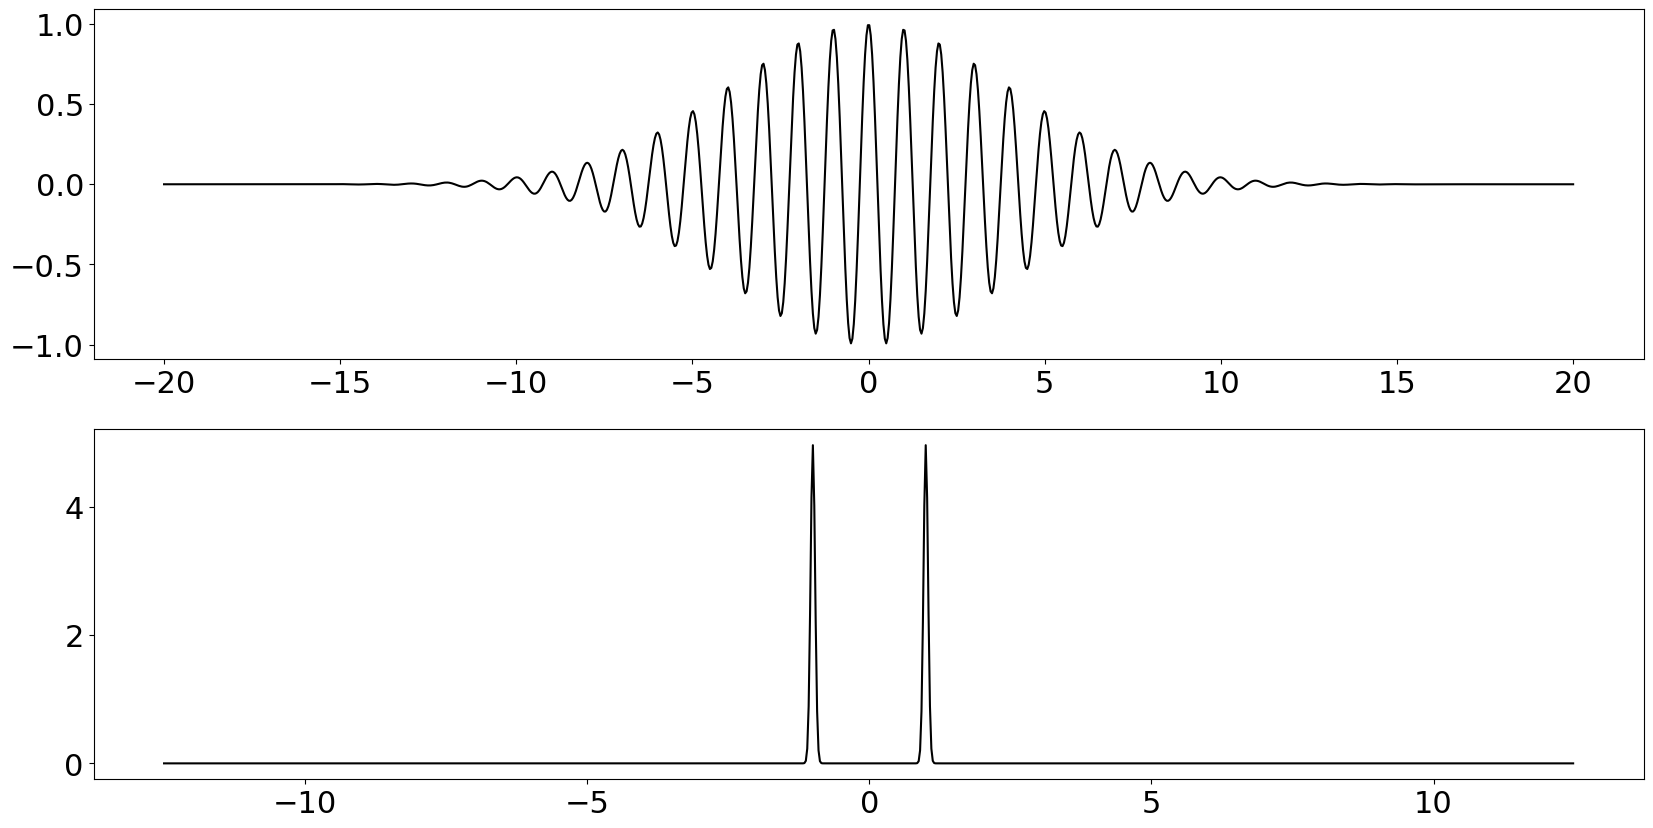

In [ ]:
xrange=np.linspace(-20,20,1000)
def fx(x):
  fxx=np.exp(-0.01*np.pi*x**2)
  fxx=fxx*np.cos(2*np.pi*x)
  return fxx
plt.subplot(2,1,1)
plt.plot(xrange,fx(xrange), 'k')
plt.subplot(2,1,2)
urange=np.arange(-500./40.,500./40.,1./40.)
plt.plot(urange,(1./(urange[-1]-urange[0]))*np.real(np.fft.fftshift(np.fft.fft(np.fft.fftshift(fx(xrange))))),'k')
plt.savefig('harmonicGaussian.png')
#files.download('harmonicGaussian.png')

The Fourier transform of $f(x)$ consists of the convolution of the gaussian and a delta function at $u=1$. In the plot above $\Delta x=40/1000=0.004$ and $2X=40$, Taking the discrete Fourier transform, $\delta u=1/40$ and $2B=1000/40$. We note that numpy defines the discrete Fourier transform of a vector $\mathbf{a}$ as
$${\hat a}= \sum_{n=0}^{N-1}a_n e^{-i 2\pi \frac{nn'}{N}}$$
and the inverse DFT as
$$ a= \frac{1}{N}\sum_{n=0}^{N-1}{\hat a}_n e^{i 2\pi \frac{nn'}{N}}$$
so ${\hat a}$ approximates the Fourier transform scaled by $1/\delta x=2B$ and the inverse DFT approximates the Fourier transform scaled by $1/N\delta u=1/2B$.

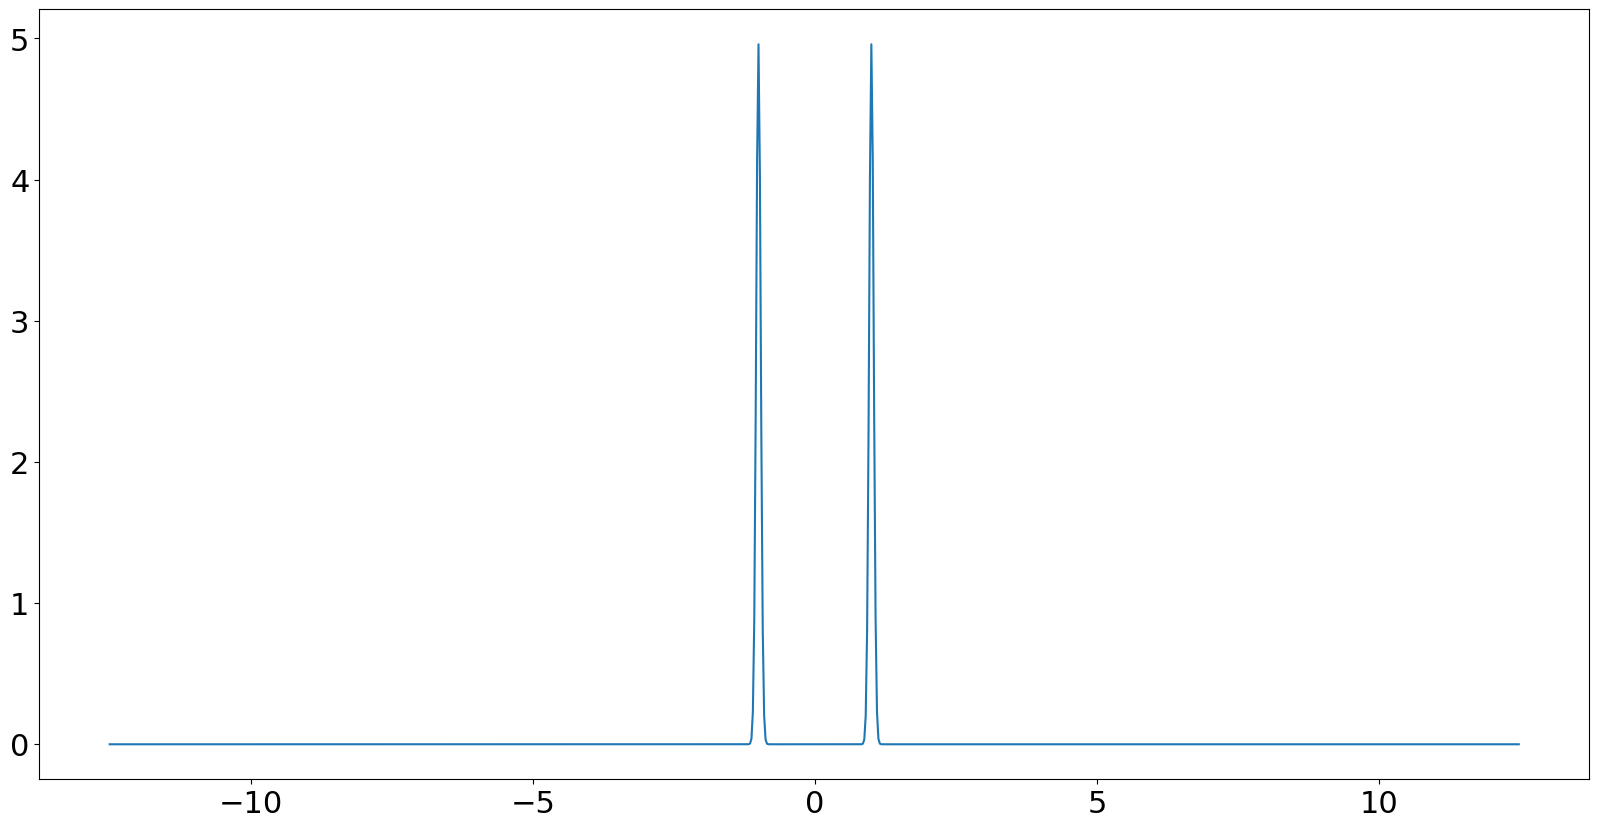

In [ ]:
urange=np.arange(-500./40.,500./40.,1./40.)
plt.plot(urange,(1./(urange[-1]-urange[0]))*np.real(np.fft.fftshift(np.fft.fft(np.fft.fftshift(fx(xrange))))))
plt.savefig('harmonicGaussianFT.png')
#files.download('harmonicGaussianFT.png')

Suppose we sample the signal at rate $\delta x$. To be above Nyquist, we might set $\delta x=.4$, corresponding to $B=1.5$. A plot of the sampled values looks like this

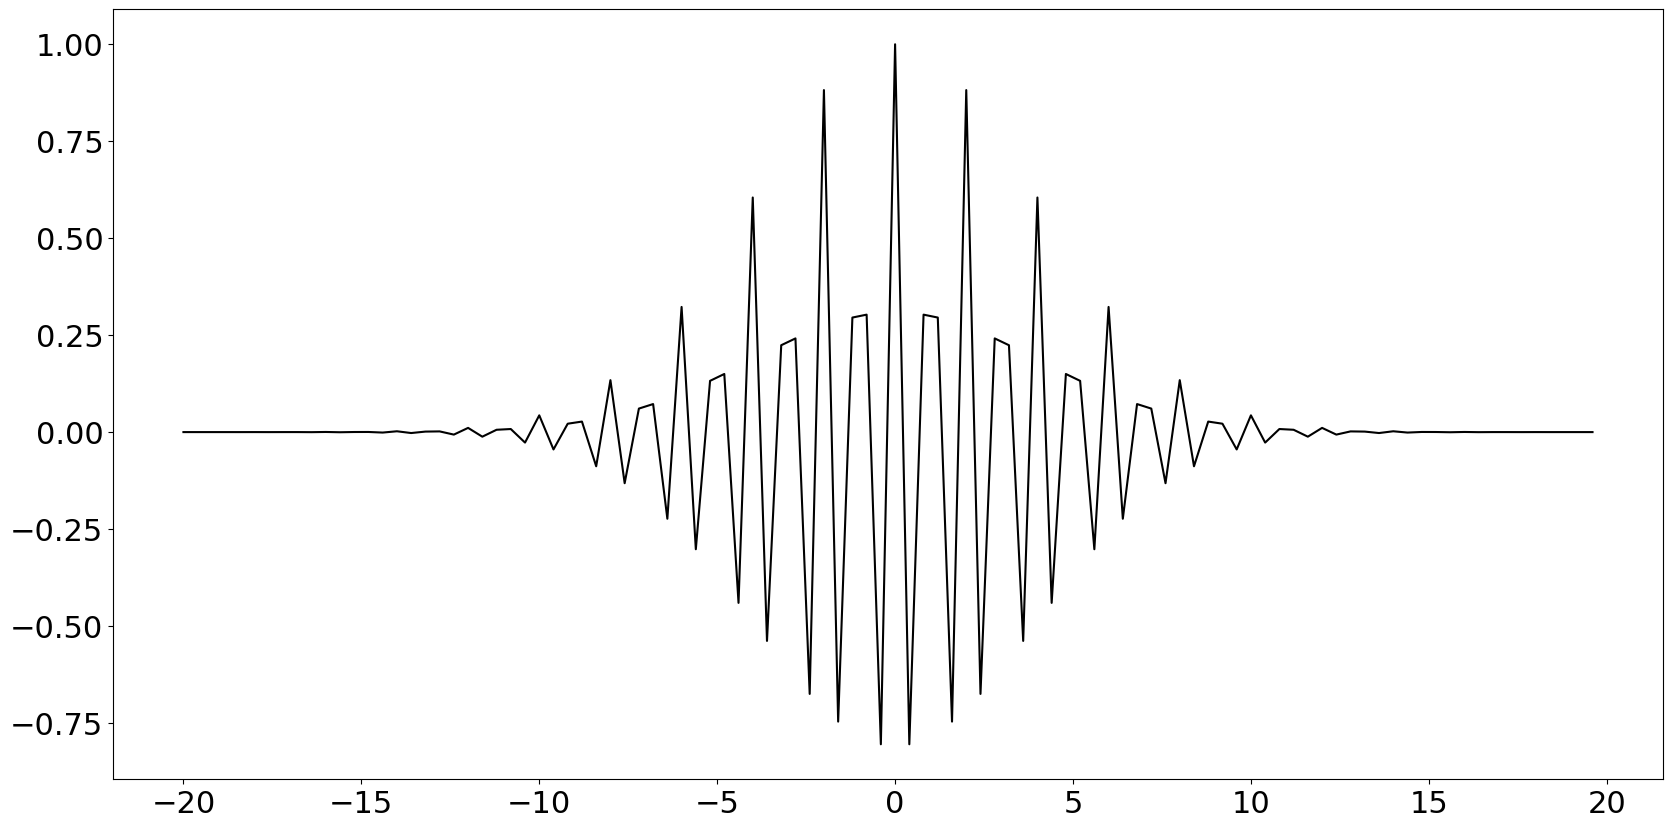

In [ ]:
srange=np.arange(-20,20,.4)
plt.plot(srange,fx(srange),'k')


plt.savefig('harmonicGaussianSample.png')
#files.download('harmonicGaussianSample.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

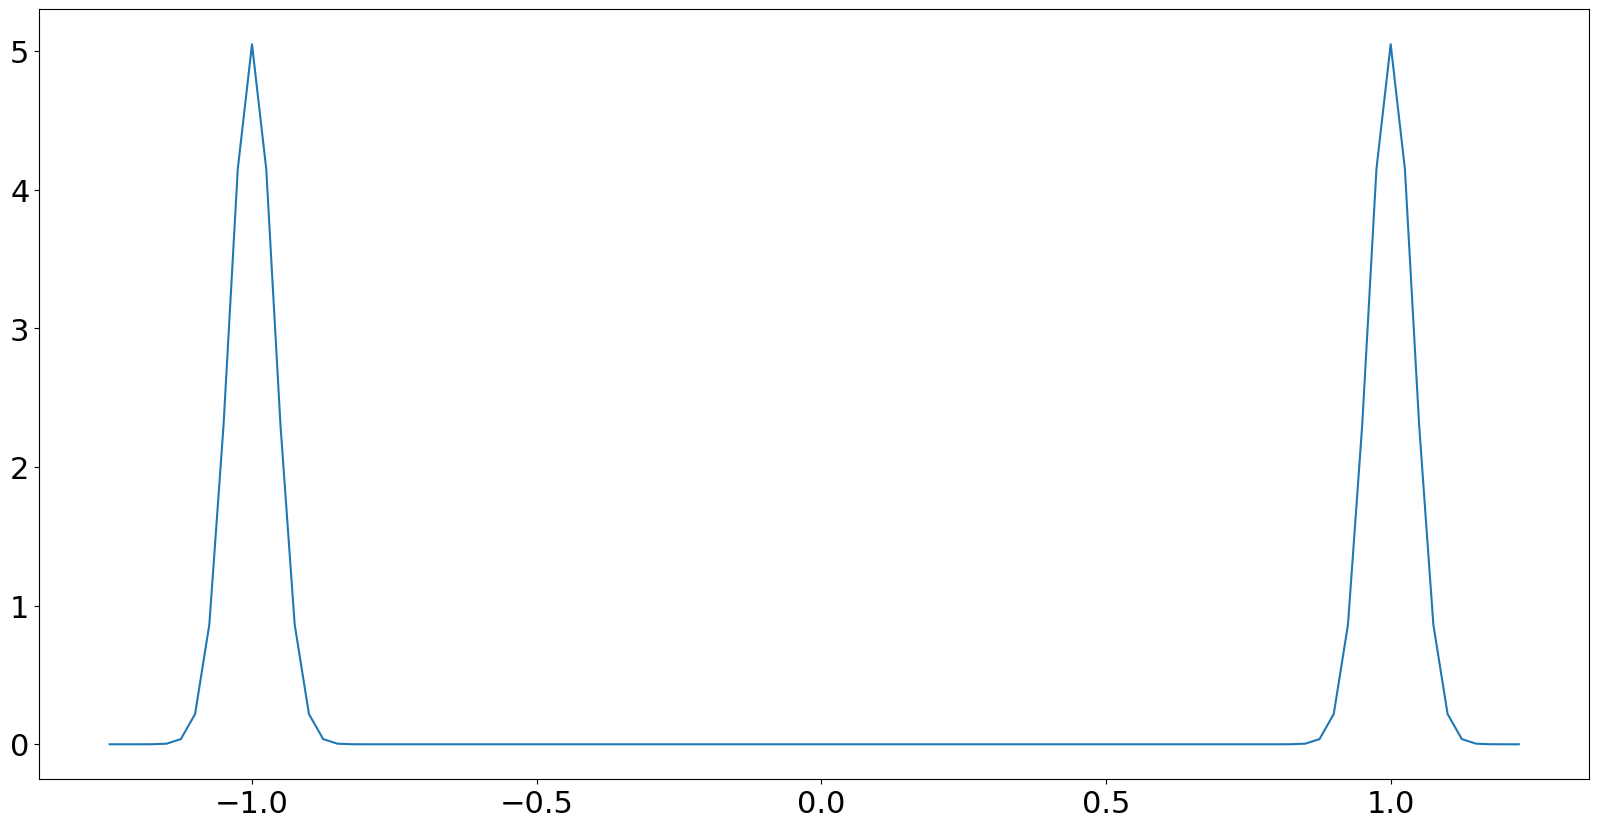

In [ ]:
usrange=srange/(.4*40.)
plt.plot(usrange,(1./(usrange[-1]-usrange[0]))*np.real(np.fft.fftshift(np.fft.fft(np.fft.fftshift(fx(srange))))))
plt.savefig('harmonicGaussianSampleFT.png')
files.download('harmonicGaussianSampleFT.png')


We can estimate $f(x)$ according to the sampling theorem. We replace each sample point by sinc(x) centered on the sampling point and scaled by the sample value. We can then reconstruct the interpolated signal by adding across the several sinc's as shown below.

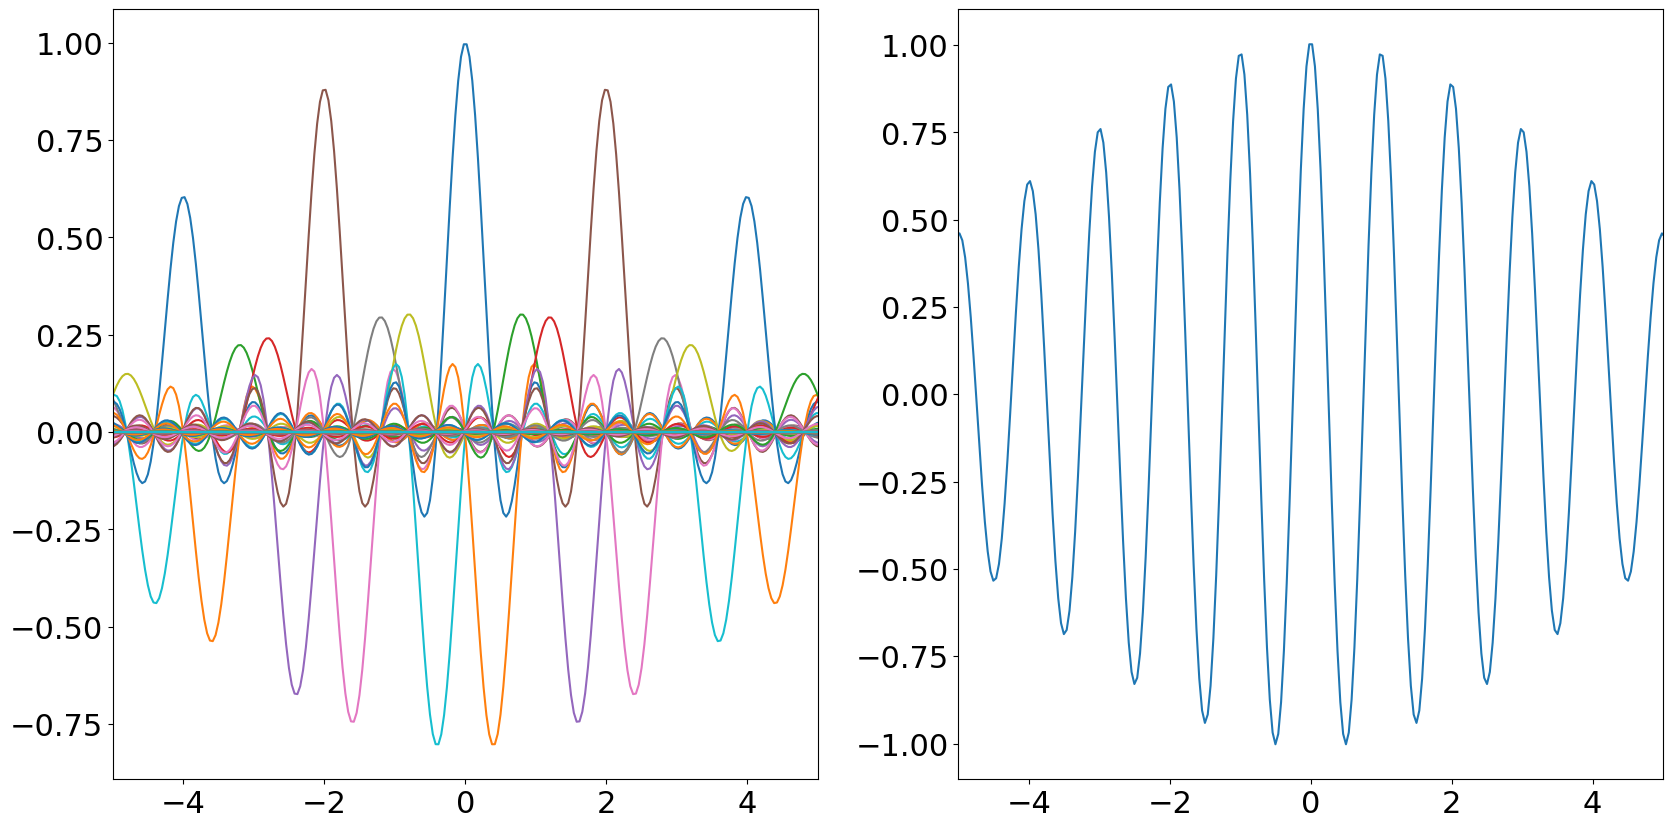

In [ ]:
usrange=srange/(.4*40.)
interP=np.zeros(1000)
for pip in np.arange(len(srange)):
  plt.subplot(1,2,1)
  plt.plot(xrange,fx(srange[pip])*np.sinc((usrange[-1]-usrange[0])*(xrange-srange[pip])))
  interP=interP+fx(srange[pip])*np.sinc((usrange[-1]-usrange[0])*(xrange-srange[pip]))
plt.xlim(-5,5)
plt.subplot(1,2,2)
plt.plot(xrange,interP)
plt.xlim(-5,5)
plt.savefig('harmonicGaussianInterp.png')
#files.download('harmonicGaussianInterp.png')

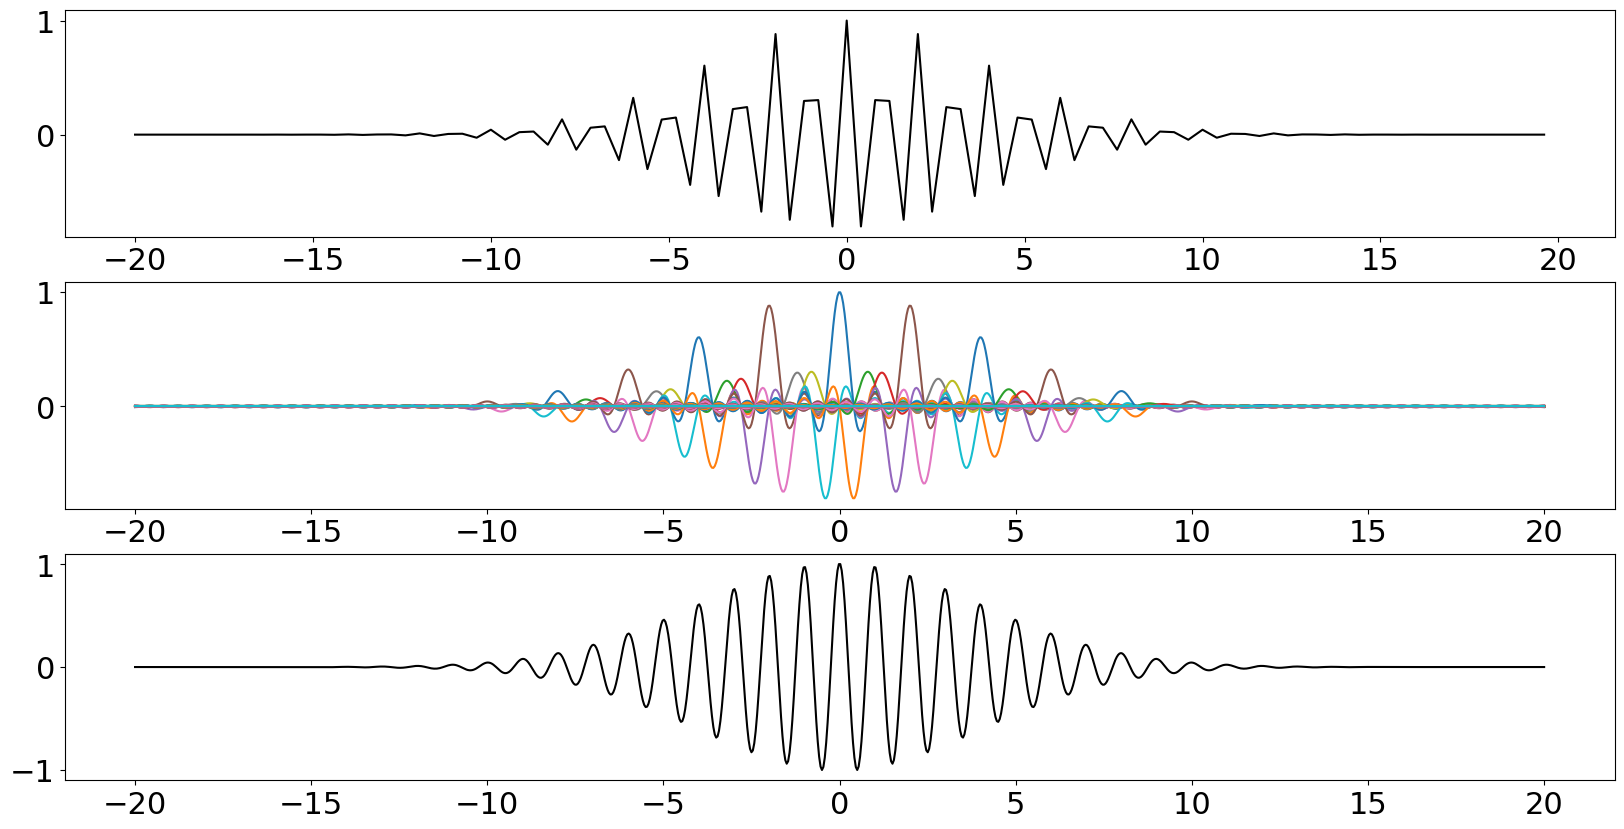

In [ ]:

srange=np.arange(-20,20,.4)
plt.subplot(3,1,1)
plt.plot(srange,fx(srange),'k')
interP=np.zeros(1000)
for pip in np.arange(len(srange)):
  plt.subplot(3,1,2)
  plt.plot(xrange,fx(srange[pip])*np.sinc((usrange[-1]-usrange[0])*(xrange-srange[pip])))
  interP=interP+fx(srange[pip])*np.sinc((usrange[-1]-usrange[0])*(xrange-srange[pip]))
plt.subplot(3,1,3)
plt.plot(xrange,interP,'k')
plt.savefig('harmonicGaussianInterp.png')

Alternatively, we note that decreasing $1/\delta x$ corresponds to increasing $B$. So we "zero pad" the Fourier transform and then inverse FT, we return the upsampled signal.

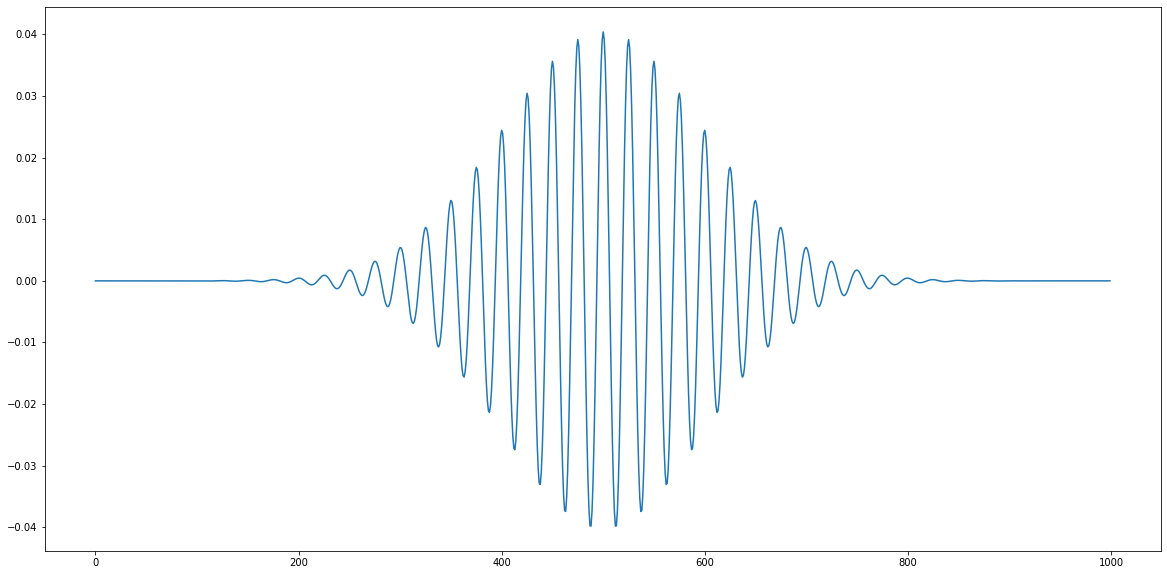

In [ ]:
fftP=0.*urange;
fftP[(np.int(len(fftP)/2)-np.int(len(srange)/2)):(np.int(len(fftP)/2)-np.int(len(srange)/2)+len(srange))]=(1./(usrange[-1]-usrange[0]))*np.fft.fftshift(np.fft.fft(np.fft.fftshift(fx(srange))));
plt.plot(np.real(np.fft.fftshift(np.fft.ifft(np.fft.fftshift(fftP)))))


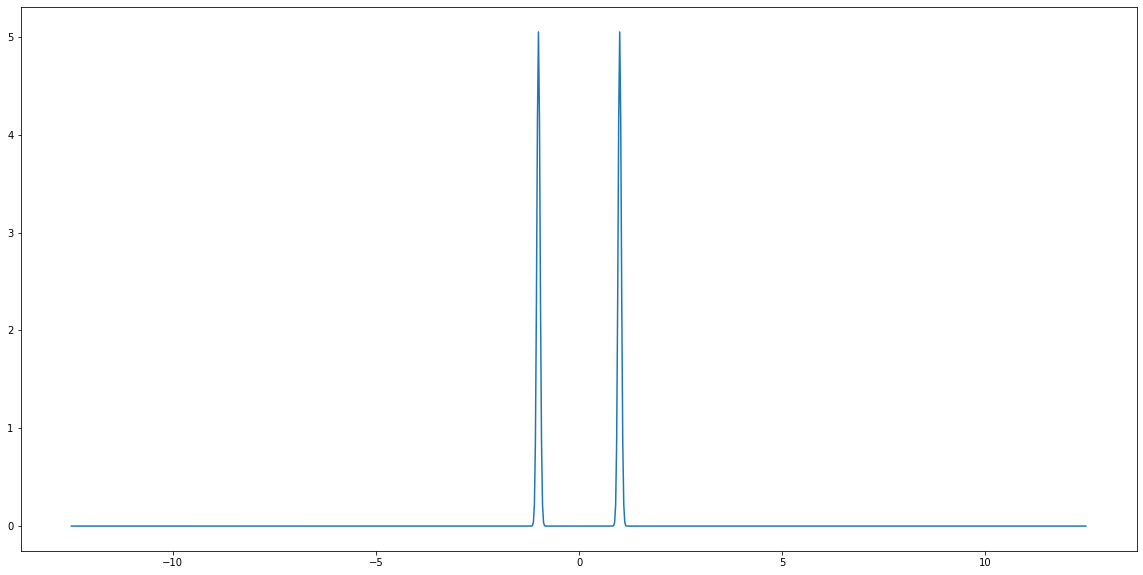

In [ ]:
plt.plot(urange,np.abs(fftP))

What happens if we undersample?

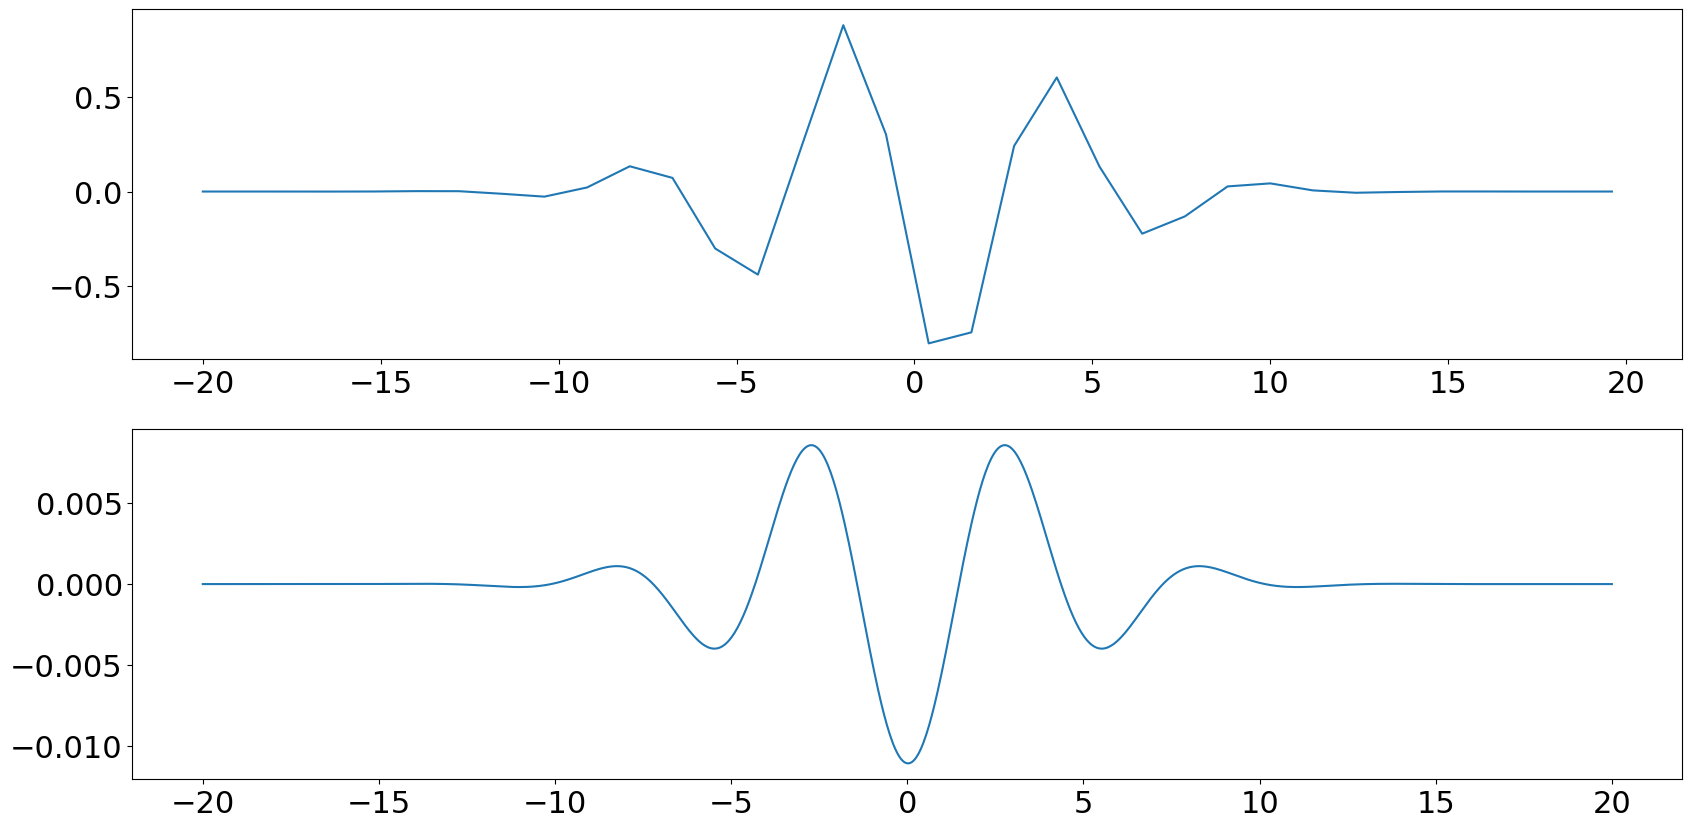

In [ ]:
srange=np.arange(-20,20,1.2)
plt.subplot(2,1,1)
plt.plot(srange,fx(srange))
plt.subplot(2,1,2)
fftP=0.*urange;
fftP[(np.int64(len(fftP)/2)-np.int64(len(srange)/2)):(np.int64(len(fftP)/2)-np.int64(len(srange)/2)+len(srange))]=(1./(usrange[-1]-usrange[0]))*np.fft.fftshift(np.fft.fft(np.fft.fftshift(fx(srange))));
plt.plot(xrange,np.real(np.fft.fftshift(np.fft.ifft(np.fft.fftshift(fftP)))))
plt.savefig('harmonicGaussianUnder.png')
#files.download('harmonicGaussianUnderSample.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

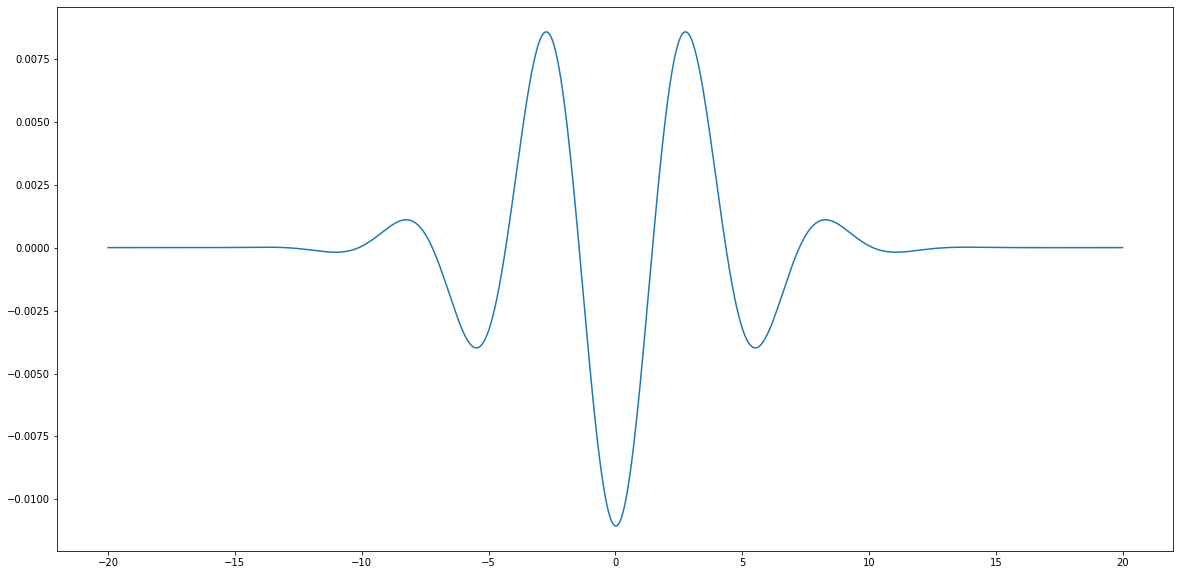

In [ ]:
fftP=0.*urange;
fftP[(np.int(len(fftP)/2)-np.int(len(srange)/2)):(np.int(len(fftP)/2)-np.int(len(srange)/2)+len(srange))]=(1./(usrange[-1]-usrange[0]))*np.fft.fftshift(np.fft.fft(np.fft.fftshift(fx(srange))));
plt.plot(xrange,np.real(np.fft.fftshift(np.fft.ifft(np.fft.fftshift(fftP)))))
plt.savefig('harmonicGaussianUnderSampleInterp.png')
files.download('harmonicGaussianUnderSampleInterp.png')